## imports

In [180]:
import numpy as np
import pandas as pd
from string import digits
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy, pearsonr
from scipy.spatial.distance import cdist
from collections import OrderedDict
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import hypertools as hyp
import scipy
import numpy as np
import os

%matplotlib inline
sns.set_context('talk')

## set paths

In [2]:
vid_transc_dir = '../video transcript analysis'
answers_dir = '../graded_answers/'
figdir = '../../figures/'

## load lesson and question data

In [3]:
# Four forces
forces_video_df = pd.read_csv(os.path.join(vid_transc_dir,'fourforcesdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])

# already formatted as sliding windows
forces_video_samples = forces_video_df[0].tolist()

In [4]:
# birth of stars
bos_video_df = pd.read_csv(os.path.join(vid_transc_dir, 'birthofstarsdiced.tsv'), 
                            error_bad_lines=False, header=None, sep='\t', usecols=[0])

# already formatted as sliding windows
bos_video_samples = pd.Series(bos_video_df[0]).tolist()

In [5]:
# questions
questions_df = pd.read_csv('../data analysis/astronomyquestions.tsv', sep='\t', 
            names=['index', 'video', 'question', 'ans_A', 'ans_B', 'ans_C', 'ans_D'], index_col='index') 

forces_questions_samples = questions_df.loc[questions_df.video == 1].question.tolist()
bos_questions_samples = questions_df.loc[questions_df.video == 2].question.tolist()
general_question_samples = questions_df.loc[questions_df.video == 0].question.tolist()

In [6]:
# link question text to qID
question_dict = {qid : questions_df.loc[qid].question for qid in questions_df.index}

## load and format participant answer data

In [7]:
data_df = pd.read_csv(os.path.join(answers_dir, 'Graded_results_19s.csv'), index_col='Unnamed: 0')

In [8]:
# format as diction {participantID : data}
sub_data = dict()

for sub in data_df.participantID.unique():
    sub_data[sub] = data_df.loc[data_df.participantID == sub].drop('participantID', axis=1).reset_index(drop=True)

sub_data[1].head()

,correct?,qID,set,video
0,1,13,0,1
1,0,21,0,2
2,0,12,0,1
3,1,16,0,2
4,1,28,0,2


## define some functions

In [9]:
vec_params = {
    'max_df': 0.95,
    'min_df': 2,
    'max_features': 500,
    'stop_words': 'english'
}

lda_params = {
    'n_components': 20,
    'max_iter': 10,
    'learning_method': 'online',
    'learning_offset':50.,
    'random_state': 0
}

In [10]:
def model_lessons_questions(v_windows, q_windows, vec_params, lda_params):
    """
    Fit a topic model to video and question content, use it to transform videos and questions.
    Returns a tuple: (video topic proportions, question topic proportions, fit topic model)
    """
    
    # initialize count vectorizer
    tf_vectorizer = CountVectorizer(**vec_params)
    # fit the model
    tf_vectorizer.fit(v_windows+q_windows)

    # transform video windows
    video_tf = tf_vectorizer.transform(v_windows)

    # transform question samples
    questions_tf = tf_vectorizer.transform(q_windows)

    both_tf = tf_vectorizer.transform(v_windows+q_windows)

    # initialize topic model
    lda = LatentDirichletAllocation(**lda_params)

    # fit topic model to video and questions
    lda.fit(both_tf)

    # transform video
    video_topics = lda.transform(video_tf)

    # smooth video model
    video_topics = pd.DataFrame(video_topics).rolling(25).mean().loc[25:,:].values

    # transform questions
    questions_topics = lda.transform(questions_tf)
    
    return video_topics, questions_topics, lda


In [11]:
def reconstruct_trace(video_model, questions_model, acc):
    """
    Function that reconstructs memory trajectory based on video model and a set of correctly answered questions
    """
    
    def normalize(x):
        xs = x - np.min(x)
        return np.divide(xs, np.max(xs))
    
    def z2r(z):
        return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)
    
    def r2z(r):
        return 0.5 * (np.log(1 + r) - np.log(1 - r))
    
    def symmetric_KL(a, b, c=.00000000001):
        return np.divide(entropy(a+c,b+c)+entropy(b+c,a+c), 2)

    # compute timepoints by questions correlation matrix
    wz = 1-scipy.spatial.distance.cdist(video_model, questions_model, symmetric_KL)
    
    # add the minimum value
    wz-=np.min(wz)
    
    # divide by the max value
    wz/=np.max(wz)
    
    # sum over columns
    a = np.sum(wz, axis=1)
 
    # sum over columns for correct answers
    b = np.sum(wz[:, list(map(bool, acc))], axis=1)
    
    # divide b by a
    ba = np.array(np.divide(b,a), ndmin=2)
    
    # weight the model
    return video_model*ba.T

In [12]:
def pcorrect_msd(video_topics, subject, n_questions, n_perms, p_correct = [0, .05, .25, .50, .75, .95, 1]):
    """
    Function that computes the MSD between video and question models as a function of p(correct answer)
    """
    
    dist = []
    for pc in p_correct:
        dists = []
        for perm in range(n_perms):
            acc = np.random.binomial(1, pc, n_questions).astype(int)
            recon = forces_traces_by_sub[subject]
            dists.append(np.mean(video_topics-recon)**2)
        dist.append(dists)
    return dist

# _Four Forces_

### model lecture video and questions

In [13]:
forces_v_traj, forces_q_traj, forces_tm = model_lessons_questions(forces_video_samples, forces_questions_samples, 
                                                           vec_params, lda_params)

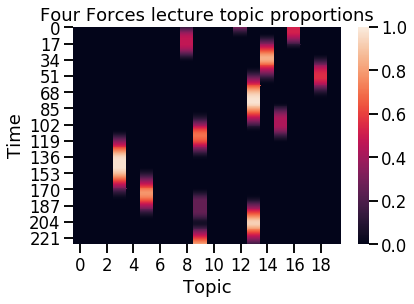

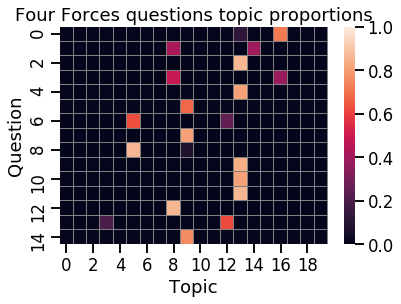

In [14]:
sns.heatmap(forces_v_traj, vmin=0, vmax=1)
plt.title('Four Forces lecture topic proportions')
plt.xlabel('Topic')
plt.ylabel('Time')
# plt.savefig(figdir+'forces-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()

sns.heatmap(forces_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
plt.title('Four Forces questions topic proportions')
plt.xlabel('Topic')
plt.ylabel('Question')
# plt.savefig(figdir+'forces-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

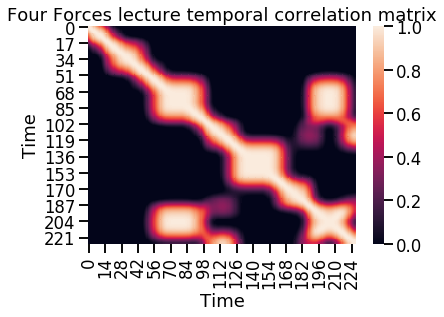

In [15]:
sns.heatmap(pd.DataFrame(forces_v_traj).T.corr(), vmin=0, vmax=1)
plt.title('Four Forces lecture temporal correlation matrix')
plt.xlabel('Time')
plt.ylabel('Time')
# plt.savefig(figdir+'forces-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

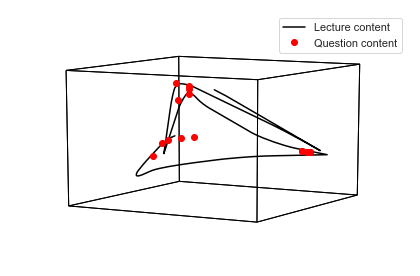

In [16]:
sns.set_context('notebook')
hyp.plot([forces_v_traj, forces_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [17]:
sns.set_palette('hls')
sns.set_context('talk')

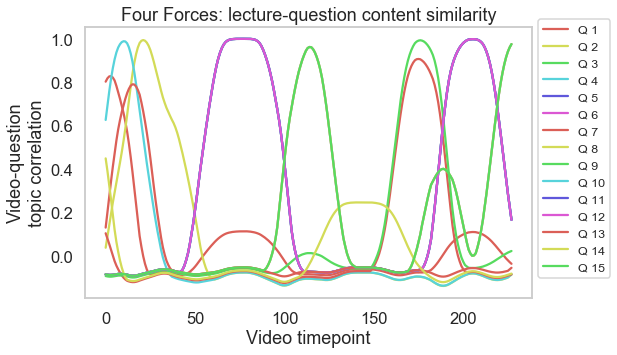

In [18]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(forces_v_traj, forces_q_traj, 'correlation'))
plt.xlabel('Video timepoint')
plt.ylabel('Video-question\ntopic correlation')
plt.title('Four Forces: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(forces_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
plt.grid(False)
# plt.savefig(figdir+'forces-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [19]:
forces_traces_set0 = {}
forces_traces_set1 = {}
forces_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 1]
    # extract their topic vectors by index
    set0_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    forces_traces_set0[sid] = reconstruct_trace(forces_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 1]
    # extract their topic vectors by index
    set1_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    forces_traces_set1[sid] = reconstruct_trace(forces_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 1]
    # extract their topic vectors by index
    set2_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    forces_traces_set2[sid] = reconstruct_trace(forces_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [20]:
avg_force_trace0 = np.mean(list(forces_traces_set0.values()), axis=0)
avg_force_trace1 = np.mean(list(forces_traces_set1.values()), axis=0)
avg_force_trace2 = np.mean(list(forces_traces_set2.values()), axis=0)

In [21]:
sns.set_context('notebook')

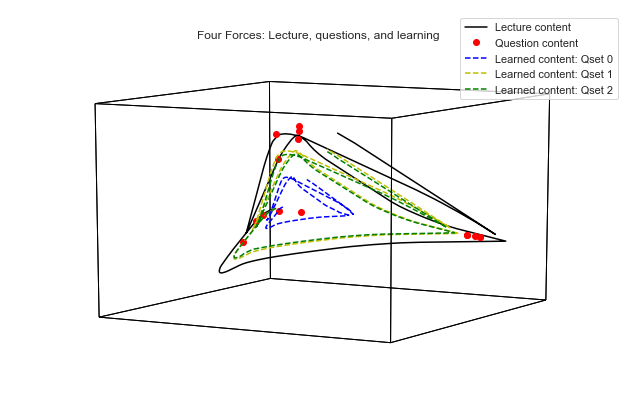

In [22]:
hyp.plot([forces_v_traj, forces_q_traj, avg_force_trace0, avg_force_trace1, avg_force_trace2], 
         fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
         title='Four Forces: Lecture, questions, and learning',
         legend=['Lecture content', 'Question content', 
                 'Learned content: Qset 0', 
                 'Learned content: Qset 1', 
                 'Learned content: Qset 2'])#, save_path='/Users/paxtonfitzpatrick/Desktop/forces-reconstructed.pdf')

# ax1.legend(labels = ['Lecture content', 'Question content', 
#                  'Learning trajectory: Qset 0', 
#                  'Learning trajectory: Qset 1', 
#                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [23]:
# pairwise euclidean distance (slightly less exact than np.diag of scipy.spatial.distance.cdist)
def distance(x, y):
    return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [24]:
distances = np.array([np.diag(cdist(forces_v_traj, aft, metric='euclidean')) 
                      for aft in [avg_force_trace0, avg_force_trace1, avg_force_trace2]]).T

perfect = np.array([0 for i in range(forces_v_traj.shape[0])], ndmin=2).T

In [25]:
sns.set_palette('hls')
sns.set_style('ticks')
sns.set_context('talk')

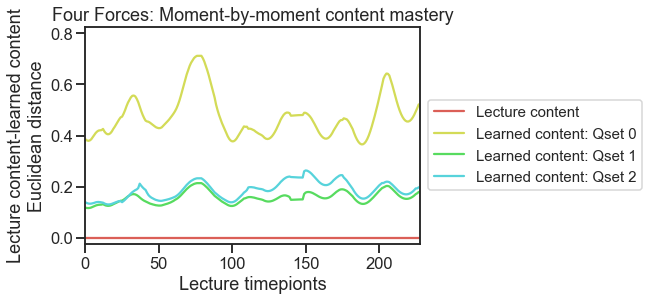

In [26]:
plt.plot(np.hstack([perfect, distances]))
plt.ylim(-.025, .825)
plt.xlim(0, forces_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Four Forces: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# plt.savefig(figdir+'forces-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

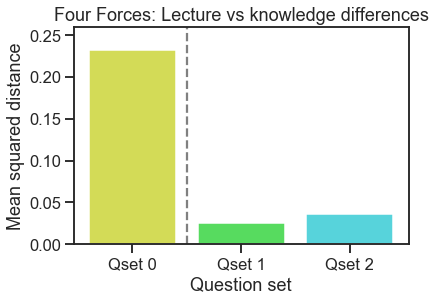

In [27]:
plt.bar(x=list(range(3)), height=(distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.26)
plt.xlabel('Question set')
plt.ylabel('Mean squared distance')
plt.title('Four Forces: Lecture vs knowledge differences')
plt.vlines(x=.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig(figdir+'forces-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

# _Birth of Stars_

### model lecture video and questions

In [28]:
bos_v_traj, bos_q_traj, bos_tm = model_lessons_questions(bos_video_samples, bos_questions_samples, 
                                                           vec_params, lda_params)

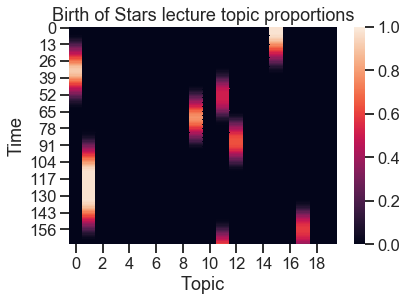

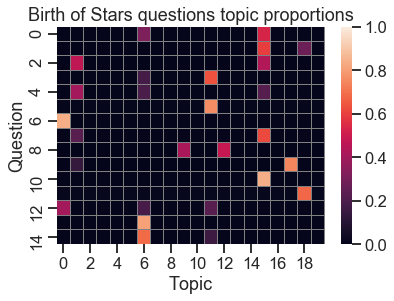

In [29]:
sns.heatmap(bos_v_traj, vmin=0, vmax=1)
plt.title('Birth of Stars lecture topic proportions')
plt.xlabel('Topic')
plt.ylabel('Time')
# plt.savefig(figdir+'bos-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()

sns.heatmap(bos_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
plt.title('Birth of Stars questions topic proportions')
plt.xlabel('Topic')
plt.ylabel('Question')
# plt.savefig(figdir+'bos-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

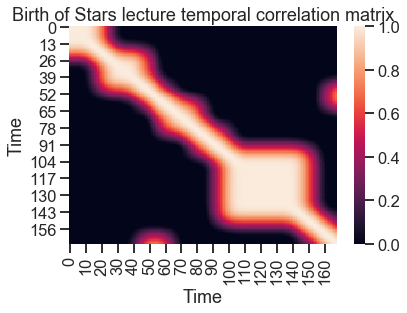

In [30]:
sns.heatmap(pd.DataFrame(bos_v_traj).T.corr(), vmin=0, vmax=1)
plt.title('Birth of Stars lecture temporal correlation matrix')
plt.xlabel('Time')
plt.ylabel('Time')
# plt.savefig(figdir+'bos-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

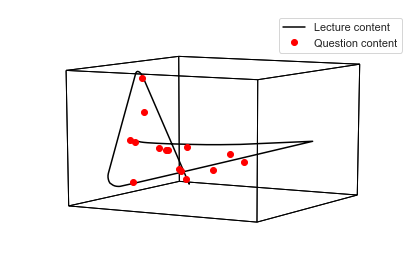

In [31]:
sns.set_context('notebook')
hyp.plot([bos_v_traj, bos_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [32]:
sns.set_palette('hls')
sns.set_context('talk')

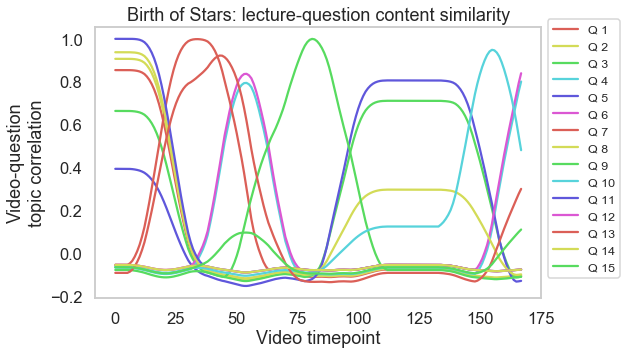

In [33]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(bos_v_traj, bos_q_traj, 'correlation'))
plt.xlabel('Video timepoint')
plt.ylabel('Video-question\ntopic correlation')
plt.title('Birth of Stars: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(bos_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
plt.grid(False)
# plt.savefig(figdir+'bos-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [34]:
bos_traces_set0 = {}
bos_traces_set1 = {}
bos_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 2]
    # extract their topic vectors by index
    set0_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    bos_traces_set0[sid] = reconstruct_trace(bos_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 2]
    # extract their topic vectors by index
    set1_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    bos_traces_set1[sid] = reconstruct_trace(bos_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 2]
    # extract their topic vectors by index
    set2_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    bos_traces_set2[sid] = reconstruct_trace(bos_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [35]:
avg_bos_trace0 = np.mean(list(bos_traces_set0.values()), axis=0)
avg_bos_trace1 = np.mean(list(bos_traces_set1.values()), axis=0)
avg_bos_trace2 = np.mean(list(bos_traces_set2.values()), axis=0)

In [36]:
sns.set_context('notebook')

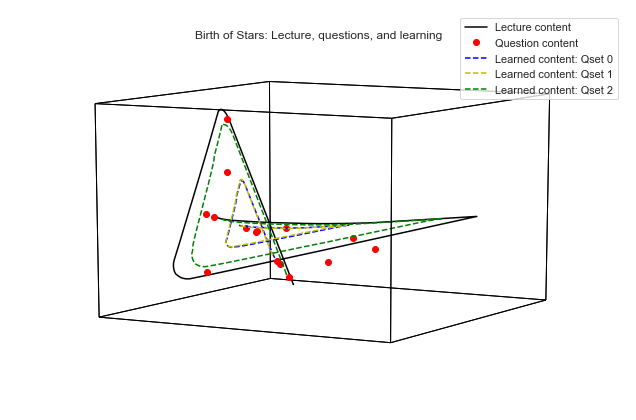

In [37]:
hyp.plot([bos_v_traj, bos_q_traj, avg_bos_trace0, avg_bos_trace1, avg_bos_trace2], 
         fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
         title='Birth of Stars: Lecture, questions, and learning',
         legend=['Lecture content', 'Question content', 
                 'Learned content: Qset 0', 
                 'Learned content: Qset 1', 
                 'Learned content: Qset 2'])#, save_path=figdir+'bos-reconstructed.pdf')

# ax1.legend(labels = ['Lecture content', 'Question content', 
#                  'Learning trajectory: Qset 0', 
#                  'Learning trajectory: Qset 1', 
#                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [38]:
bos_distances = np.array([np.diag(cdist(bos_v_traj, abt, metric='euclidean')) 
                      for abt in [avg_bos_trace0, avg_bos_trace1, avg_bos_trace2]]).T

bos_perfect = np.array([0 for i in range(bos_v_traj.shape[0])], ndmin=2).T

In [39]:
sns.set_palette('hls')
sns.set_style('ticks')
sns.set_context('talk')

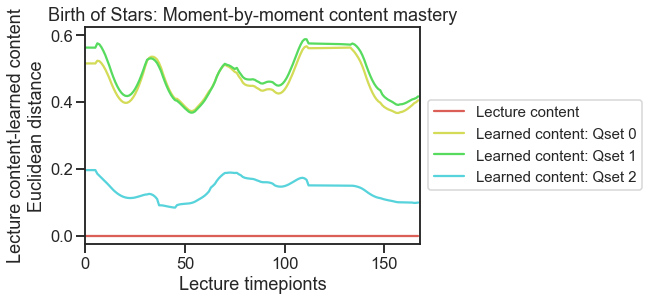

In [40]:
plt.plot(np.hstack([bos_perfect, bos_distances]))
plt.ylim(-.025, .625)
plt.xlim(0, bos_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Birth of Stars: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# plt.savefig(figdir+'bos-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

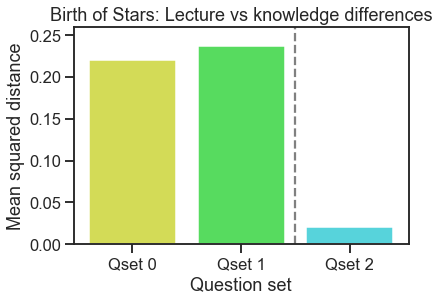

In [41]:
plt.bar(x=list(range(3)), height=(bos_distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.26)
plt.xlabel('Question set')
plt.ylabel('Mean squared distance')
plt.title('Birth of Stars: Lecture vs knowledge differences')
plt.vlines(x=1.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig(figdir+'bos-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

# re-run analyses with model fit to both lectures and question sets

In [43]:
# initialize count vectorizer
tf_vectorizer = CountVectorizer(**vec_params)

# fit to both lectures and all questions
tf_vectorizer.fit(forces_video_samples + forces_questions_samples
                  + bos_video_samples + bos_questions_samples
                  + general_question_samples)

# transform lecture windows
forces_video_tf = tf_vectorizer.transform(forces_video_samples)
bos_video_tf = tf_vectorizer.transform(bos_video_samples)

# transform question samples
forces_questions_tf = tf_vectorizer.transform(forces_questions_samples)
bos_questions_tf = tf_vectorizer.transform(bos_questions_samples)
general_questions_tf = tf_vectorizer.transform(general_question_samples)

all_tf = tf_vectorizer.transform(forces_questions_samples + bos_questions_samples + general_question_samples)

# initialize LDA model, fit to both lectures and all questions
lda = LatentDirichletAllocation(**lda_params)
lda.fit(all_tf)

# transform lectures
forces_v_traj = lda.transform(forces_video_tf)
bos_v_traj = lda.transform(bos_video_tf)

# smooth lecture models
forces_v_traj = pd.DataFrame(forces_v_traj).rolling(25).mean().loc[25:,:].values
bos_v_traj = pd.DataFrame(bos_v_traj).rolling(25).mean().loc[25:,:].values

# transform questions
forces_q_traj = lda.transform(forces_questions_tf)
bos_q_traj = lda.transform(bos_questions_tf)
general_q_traj = lda.transform(general_questions_tf)


# _Four Forces_

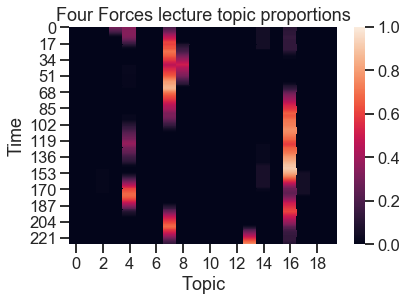

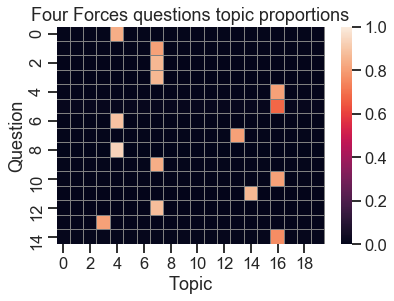

In [44]:
sns.heatmap(forces_v_traj, vmin=0, vmax=1)
plt.title('Four Forces lecture topic proportions')
plt.xlabel('Topic')
plt.ylabel('Time')
# plt.savefig(figdir+'fit_all/forces-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()

sns.heatmap(forces_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
plt.title('Four Forces questions topic proportions')
plt.xlabel('Topic')
plt.ylabel('Question')
# plt.savefig(figdir+'fit_all/forces-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

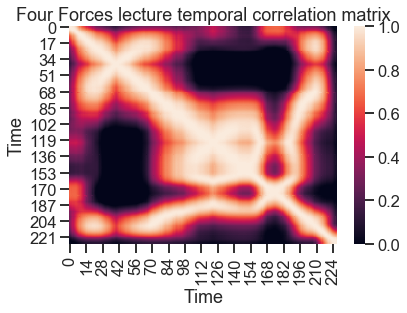

In [45]:
sns.heatmap(pd.DataFrame(forces_v_traj).T.corr(), vmin=0, vmax=1)
plt.title('Four Forces lecture temporal correlation matrix')
plt.xlabel('Time')
plt.ylabel('Time')
# plt.savefig(figdir+'fit_all/forces-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

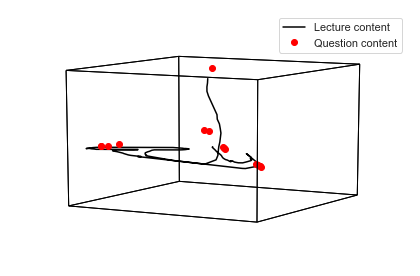

In [46]:
sns.set_context('notebook')
hyp.plot([forces_v_traj, forces_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [47]:
sns.set_palette('hls')
sns.set_context('talk')

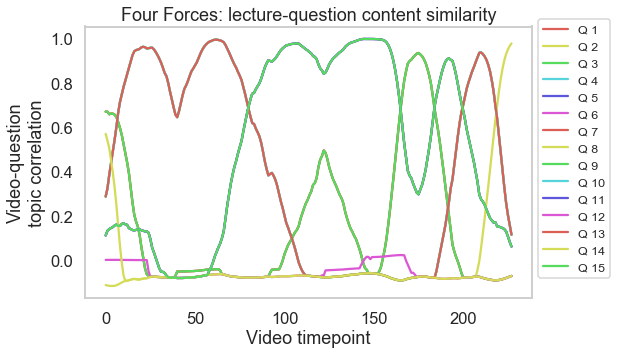

In [48]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(forces_v_traj, forces_q_traj, 'correlation'))
plt.xlabel('Video timepoint')
plt.ylabel('Video-question\ntopic correlation')
plt.title('Four Forces: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(forces_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
plt.grid(False)
# plt.savefig(figdir+'fit_all/forces-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [49]:
forces_traces_set0 = {}
forces_traces_set1 = {}
forces_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 1]
    # extract their topic vectors by index
    set0_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    forces_traces_set0[sid] = reconstruct_trace(forces_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 1]
    # extract their topic vectors by index
    set1_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    forces_traces_set1[sid] = reconstruct_trace(forces_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Four Forces viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 1]
    # extract their topic vectors by index
    set2_fqs_vecs = forces_q_traj[[forces_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    forces_traces_set2[sid] = reconstruct_trace(forces_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [50]:
avg_force_trace0 = np.mean(list(forces_traces_set0.values()), axis=0)
avg_force_trace1 = np.mean(list(forces_traces_set1.values()), axis=0)
avg_force_trace2 = np.mean(list(forces_traces_set2.values()), axis=0)

In [51]:
sns.set_context('notebook')

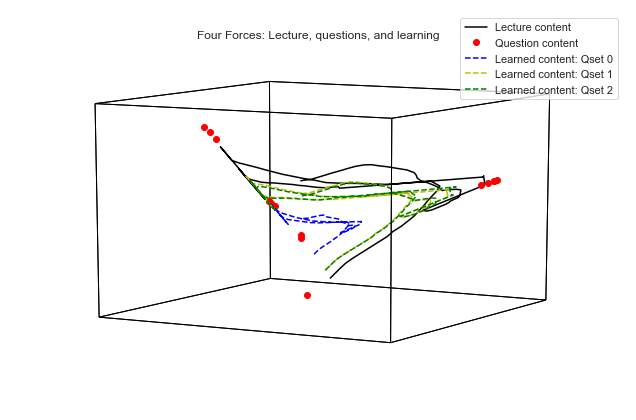

In [52]:
hyp.plot([forces_v_traj, forces_q_traj, avg_force_trace0, avg_force_trace1, avg_force_trace2], 
         fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
         title='Four Forces: Lecture, questions, and learning',
         legend=['Lecture content', 'Question content', 
                 'Learned content: Qset 0', 
                 'Learned content: Qset 1', 
                 'Learned content: Qset 2'])#, save_path=figdir+'fit_all/forces-reconstructed.pdf')

# ax1.legend(labels = ['Lecture content', 'Question content', 
#                  'Learning trajectory: Qset 0', 
#                  'Learning trajectory: Qset 1', 
#                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [53]:
# pairwise euclidean distance (slightly less exact than np.diag of scipy.spatial.distance.cdist)
def distance(x, y):
    return np.sqrt(np.dot(x, x) - 2 * np.dot(x, y) + np.dot(y, y))

In [54]:
distances = np.array([np.diag(cdist(forces_v_traj, aft, metric='euclidean')) 
                      for aft in [avg_force_trace0, avg_force_trace1, avg_force_trace2]]).T

perfect = np.array([0 for i in range(forces_v_traj.shape[0])], ndmin=2).T

In [55]:
sns.set_palette('hls')
sns.set_style('ticks')
sns.set_context('talk')

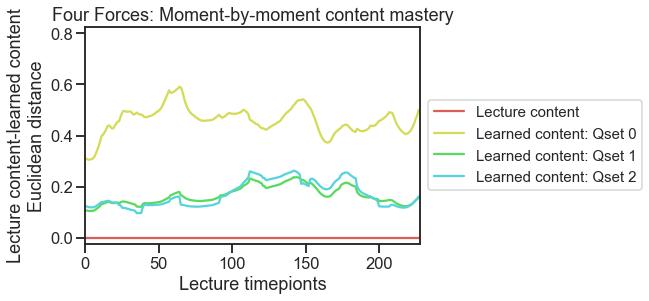

In [56]:
plt.plot(np.hstack([perfect, distances]))
plt.ylim(-.025, .825)
plt.xlim(0, forces_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Four Forces: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# plt.savefig(figdir+'fit_all/forces-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

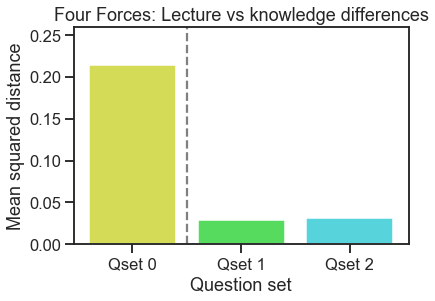

In [57]:
plt.bar(x=list(range(3)), height=(distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.26)
plt.xlabel('Question set')
plt.ylabel('Mean squared distance')
plt.title('Four Forces: Lecture vs knowledge differences')
plt.vlines(x=.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig(figdir+'fit_all/forces-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

# _Birth of Stars_

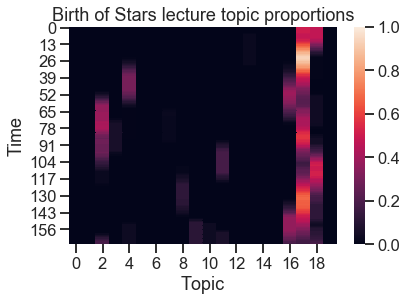

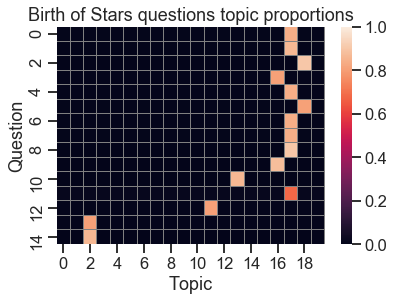

In [58]:
sns.heatmap(bos_v_traj, vmin=0, vmax=1)
plt.title('Birth of Stars lecture topic proportions')
plt.xlabel('Topic')
plt.ylabel('Time')
# plt.savefig(figdir+'fit_all/bos-lecture-toppropsmat.pdf', bbox_inches='tight')
plt.show()

sns.heatmap(bos_q_traj, vmin=0, vmax=1, linewidths=0.01, linecolor='gray')
plt.title('Birth of Stars questions topic proportions')
plt.xlabel('Topic')
plt.ylabel('Question')
# plt.savefig(figdir+'fit_all/bos-questions-toppropsmat.pdf', bbox_inches='tight')
plt.show()

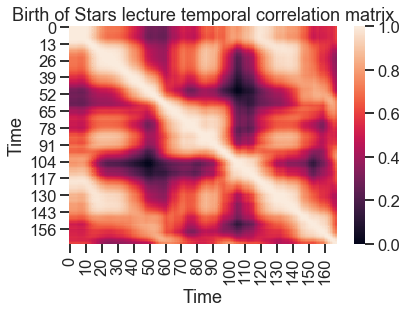

In [59]:
sns.heatmap(pd.DataFrame(bos_v_traj).T.corr(), vmin=0, vmax=1)
plt.title('Birth of Stars lecture temporal correlation matrix')
plt.xlabel('Time')
plt.ylabel('Time')
# plt.savefig(figdir+'fit_all/bos-lecture-corrmat.pdf', bbox_inches='tight')
plt.show()

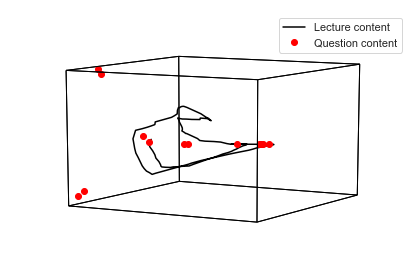

In [60]:
sns.set_context('notebook')
hyp.plot([bos_v_traj, bos_q_traj], ['k-', 'ro'], reduce='IncrementalPCA', 
         legend=['Lecture content', 'Question content'])
plt.show()

### What moments of lecture content does each question cover?

In [61]:
sns.set_palette('hls')
sns.set_context('talk')

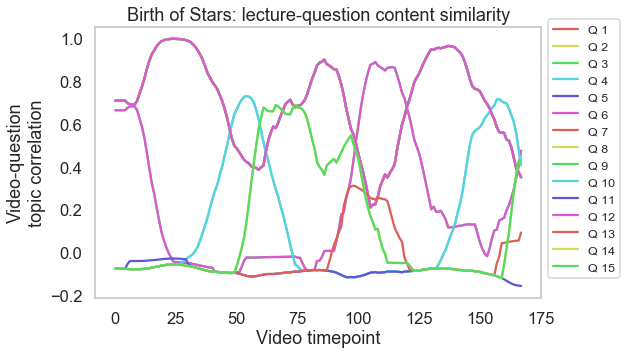

In [62]:
plt.figure(figsize=(8,5))
plt.plot(1-cdist(bos_v_traj, bos_q_traj, 'correlation'))
plt.xlabel('Video timepoint')
plt.ylabel('Video-question\ntopic correlation')
plt.title('Birth of Stars: lecture-question content similarity')
plt.legend(labels=[f'Q {i+1}' for i in range(bos_q_traj.shape[0])], fontsize='x-small', bbox_to_anchor=(1,1.05))
plt.grid(False)
# plt.savefig(figdir+'fit_all/bos-v-q-similarity.pdf', bbox_inches='tight')
plt.show()

### reconstruct eaech subject's learning trace for each set of questions viewed

In [63]:
bos_traces_set0 = {}
bos_traces_set1 = {}
bos_traces_set2 = {}

for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set0_fqs = df.loc[df.set == 0].loc[df.video == 2]
    # extract their topic vectors by index
    set0_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set0_fqs.qID]]
    # get accuracy for those questions
    set0_fqs_acc = set0_fqs['correct?']
    
    bos_traces_set0[sid] = reconstruct_trace(bos_v_traj, set0_fqs_vecs, set0_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set1_fqs = df.loc[df.set == 1].loc[df.video == 2]
    # extract their topic vectors by index
    set1_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set1_fqs.qID]]
    # get accuracy for those questions
    set1_fqs_acc = set1_fqs['correct?']
    
    bos_traces_set1[sid] = reconstruct_trace(bos_v_traj, set1_fqs_vecs, set1_fqs_acc)
    
for sid, df in sub_data.items():
    # get questions about Birth of Stars viewed in first block 
    set2_fqs = df.loc[df.set == 2].loc[df.video == 2]
    # extract their topic vectors by index
    set2_fqs_vecs = bos_q_traj[[bos_questions_samples.index(question_dict[i]) for i in set2_fqs.qID]]
    # get accuracy for those questions
    set2_fqs_acc = set2_fqs['correct?']
    
    bos_traces_set2[sid] = reconstruct_trace(bos_v_traj, set2_fqs_vecs, set2_fqs_acc)

In [64]:
avg_bos_trace0 = np.mean(list(bos_traces_set0.values()), axis=0)
avg_bos_trace1 = np.mean(list(bos_traces_set1.values()), axis=0)
avg_bos_trace2 = np.mean(list(bos_traces_set2.values()), axis=0)

In [65]:
sns.set_context('notebook')

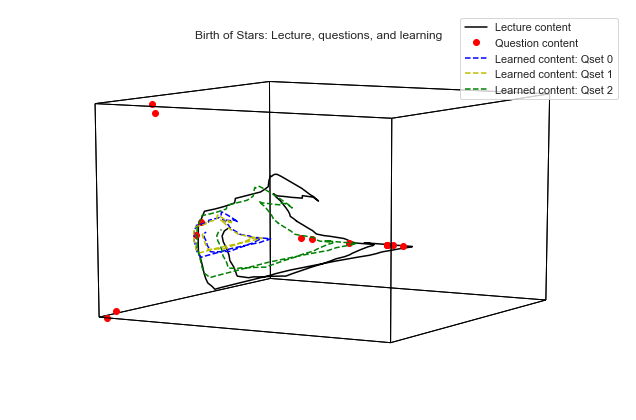

In [66]:
hyp.plot([bos_v_traj, bos_q_traj, avg_bos_trace0, avg_bos_trace1, avg_bos_trace2], 
         fmt=['k-', 'ro', 'b--', 'y--', 'g--'], reduce='IncrementalPCA', size=[9, 6],
         title='Birth of Stars: Lecture, questions, and learning',
         legend=['Lecture content', 'Question content', 
                 'Learned content: Qset 0', 
                 'Learned content: Qset 1', 
                 'Learned content: Qset 2'])#, save_path=figdir+'fit_all/bos-reconstructed.pdf')

# ax1.legend(labels = ['Lecture content', 'Question content', 
#                  'Learning trajectory: Qset 0', 
#                  'Learning trajectory: Qset 1', 
#                  'Learning trajectory: Qset 2'])

### How does the difference between viewed and learned content change after viewing the lecture?

In [67]:
bos_distances = np.array([np.diag(cdist(bos_v_traj, abt, metric='euclidean')) 
                      for abt in [avg_bos_trace0, avg_bos_trace1, avg_bos_trace2]]).T

bos_perfect = np.array([0 for i in range(bos_v_traj.shape[0])], ndmin=2).T

In [68]:
sns.set_palette('hls')
sns.set_style('ticks')
sns.set_context('talk')

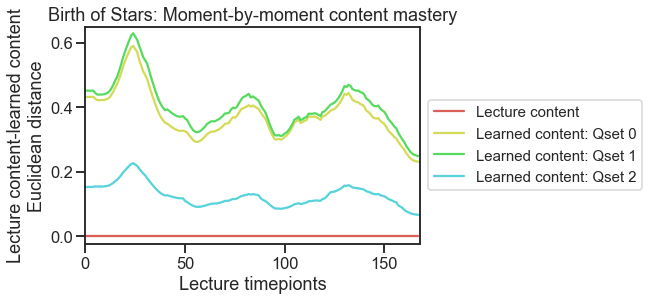

In [69]:
plt.plot(np.hstack([bos_perfect, bos_distances]))
plt.ylim(-.025, .65)
plt.xlim(0, bos_v_traj.shape[0])
plt.xlabel('Lecture timepionts')
plt.ylabel('Lecture content-learned content\nEuclidean distance')
plt.title('Birth of Stars: Moment-by-moment content mastery')
plt.legend(labels=['Lecture content','Learned content: Qset 0','Learned content: Qset 1',
                   'Learned content: Qset 2'], fontsize='small', bbox_to_anchor=(1,.7))
# plt.savefig(figdir+'fit_all/bos-lecture-trace-eucdist.pdf', bbox_inches='tight')
plt.show()

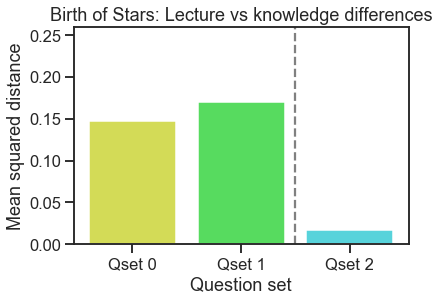

In [70]:
plt.bar(x=list(range(3)), height=(bos_distances**2).mean(axis=0), tick_label=['Qset 0', 'Qset 1', 'Qset 2'],
       color=[(0.8288, 0.86, 0.34),(0.34, 0.86, 0.3712),(0.34, 0.8288, 0.86)])
plt.ylim(0,0.26)
plt.xlabel('Question set')
plt.ylabel('Mean squared distance')
plt.title('Birth of Stars: Lecture vs knowledge differences')
plt.vlines(x=1.5, ymin=0, ymax=0.3, linestyles='dashed', colors='gray')
# plt.savefig(figdir+'fit_all/bos-msd-by-qset.pdf', bbox_inches='tight')
plt.show()

In [72]:
bos_q_traj.shape

(15, 20)

In [98]:
cdist(bos_q_traj, forces_v_traj).min(axis=1)

array([0.9670685 , 0.98781757, 1.0254314 , 0.07889699, 0.9670685 ,
       0.93821326, 0.9670685 , 0.9670685 , 1.0254314 , 0.05793176,
       0.19596299, 0.82549727, 0.93821326, 0.93821326, 0.98781757])

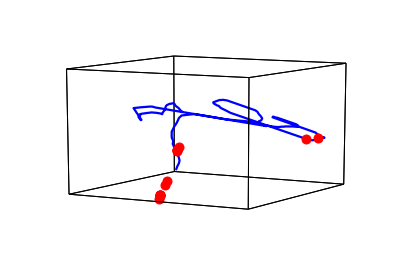

In [103]:
hyp.plot([forces_v_traj, bos_q_traj], fmt=['b-', 'ro'])

In [107]:
bos_traces_set2[1].shape

(168, 20)

### are lecture 2 questions more closely related to lecture 1 easier to get right?

In [175]:
# total number of times each question was presented in set 2 (after viewing BOS lecture)
set2_pres = data_df.loc[data_df.set == 2].loc[data_df.video == 2].qID.value_counts()
# number of times they were answered correctly
set2_correct = data_df.loc[data_df.set == 2].loc[data_df.video == 2].loc[data_df['correct?'] == 1].qID.value_counts()
# accuracy rate on those questions
set2_success = (set2_correct / set2_pres).values
# distance of those questions from nearest point on lecture 1 trajectory
lec1_dist = cdist(bos_q_traj, forces_v_traj).min(axis=1)

In [229]:
sns.set_palette('tab10')
sns.set_context('talk')
sns.set_style('whitegrid', {'axes.grid' : False})

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


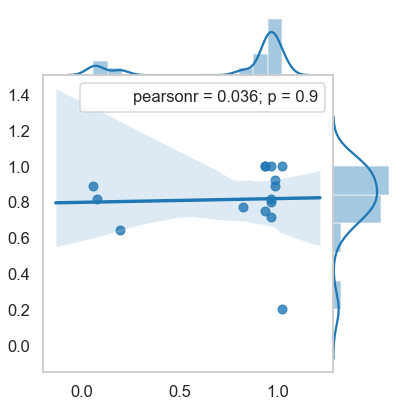

In [234]:
sns.jointplot(lec1_dist, set2_success, kind='reg', stat_func=pearsonr, space=0)
plt.show()

### are sections of lecture 2 that are more closely related to lecture 1 easier to learn?

/Users/paxtonfitzpatrick/anaconda/envs/py36/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


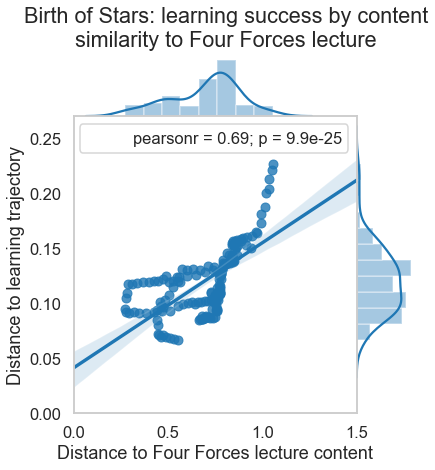

In [255]:
sns.jointplot(cdist(bos_v_traj, forces_v_traj).min(axis=1), cdist(bos_v_traj, avg_bos_trace2).min(axis=1), 
              kind='reg', stat_func=pearsonr, xlim=(0,1.5), ylim=(0,0.27), space=0)
plt.xlabel('Distance to Four Forces lecture content')
plt.ylabel('Distance to learning trajectory')
plt.suptitle('Birth of Stars: learning success by content\nsimilarity to Four Forces lecture', y=1.05)
plt.savefig(figdir+'fit_all/bos-learnability-by-ff-similarity.pdf', bbox_inches='tight')

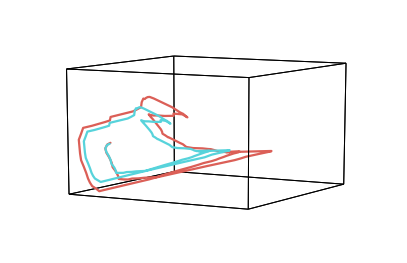

In [209]:
hyp.plot([bos_v_traj, avg_bos_trace2])